# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 224X224
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8) 

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip(p=0.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: tfimm transformer
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-4
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [91]:
!pip install -q tensorflow==2.15.0

In [92]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
from tqdm import tqdm

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import losses, optimizers, Model, layers

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image


from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow.keras.backend as K, gc


import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

tensorflow version:  2.15.0
Using 2 GPUs


In [93]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [94]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)

In [95]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [96]:
USE_CXR = True

In [97]:
df = pd.read_csv('/kaggle/input/cxr-nih-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*'))}    
df['path'] = df['Image Index'].map(tmp)

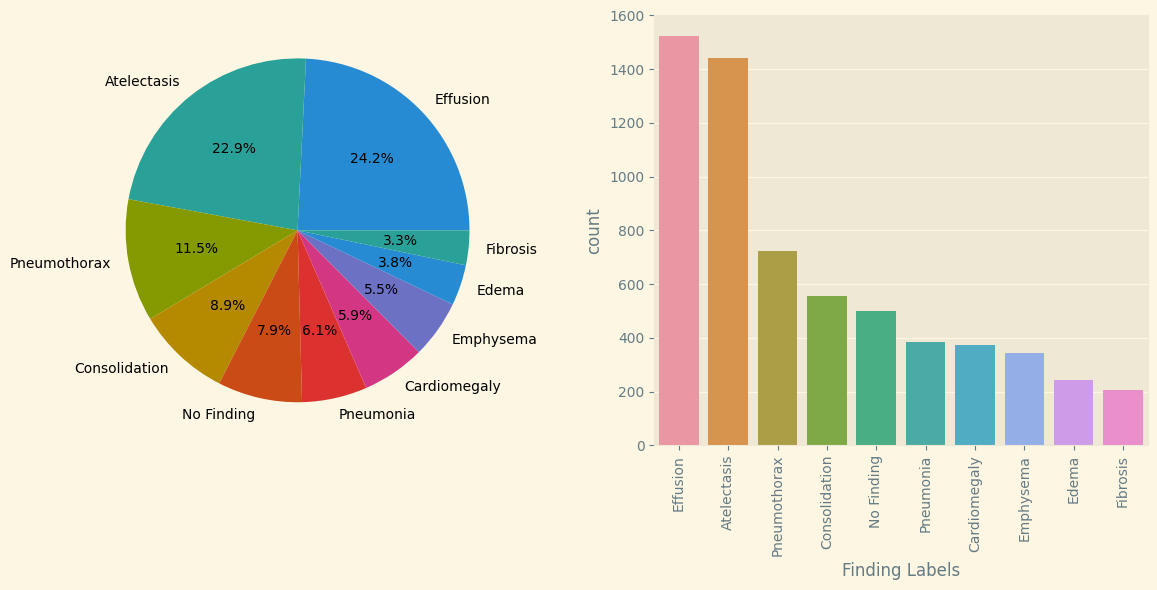

In [98]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Train & Test Split**

In [99]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [100]:
allowed_labels = ['No Finding', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumonia',
                  'Effusion', 'Pneumothorax', 'Emphysema', 'Consolidation', 'Fibrosis']

for label in allowed_labels:
    df_test[label] = df_test['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')
    df_train[label] = df_train['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

TARGET = allowed_labels

In [101]:
TARGET

['No Finding',
 'Cardiomegaly',
 'Edema',
 'Atelectasis',
 'Pneumonia',
 'Effusion',
 'Pneumothorax',
 'Emphysema',
 'Consolidation',
 'Fibrosis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [102]:
import albumentations as albu
print(albu.__version__)

1.4.14


In [103]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data,batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        if self.preprocess != None: X = self.preprocess(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            
            img = Image.open(path).convert('L')  # Load image and convert to grayscale
            img = img.resize((256, 256), Image.Resampling.LANCZOS)  # Resize image
            img = np.array(img)  # Convert PIL image to numpy array


            img = self.clahe.apply(img)  # Apply CLAHE for contrast enhancement
            img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (H, W, 1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)   
            
            
            X[j,:,:,:3] = img
            
            
            y[j,] = row[TARGET]
            
        return X,y
            
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
                 albu.OneOf([albu.HorizontalFlip(p=1.0)]
                            , p=0.5),
                 albu.OneOf([albu.Rotate(limit=5, p=1.0)]
                            ,p=0.5),

        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:  
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(2.0, 2.0)
         
                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]
            
        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build Vit Model</b></div>

In [104]:
!pip install -q tfimm

import tfimm

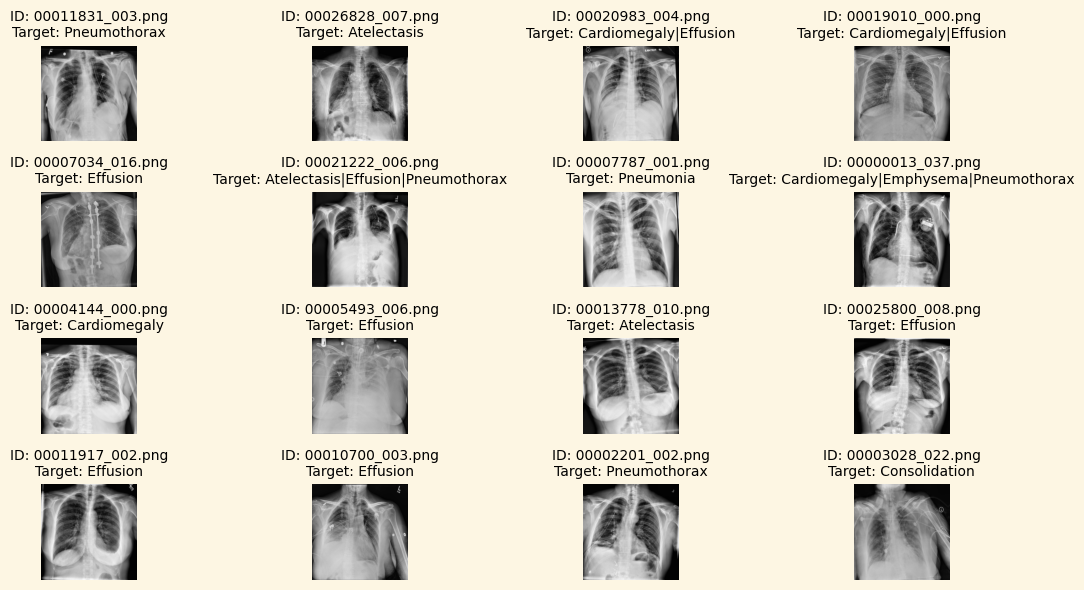

In [105]:
ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Patch Images 

In [106]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self,images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
             images=images,
             sizes=[1,self.patch_size,self.patch_size,1],
             strides = [1, self.patch_size, self.patch_size, 1],
             rates = [1,1,1,1],
             padding = 'VALID'
        )
        # patches shape=(batch size,number of patches in height,number of patches in width,patch size×patch size×channels)
        patch_dims = patches.shape[-1]
        
        # patches shape=(batch_size, number of patches, patch * patch * channel)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return patches

Image size: 256 X 256
Patch size: 16 X 16
Patches per image: 256


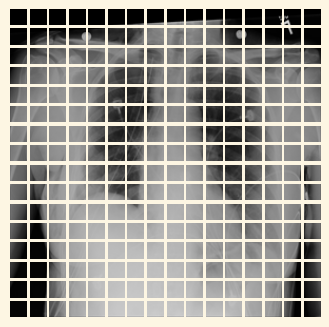

In [107]:
image_size = 256
patch_size = 16

path = df_train.iloc[0]['path']
img = Image.open(path).convert('RGB')
img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
img = np.array(img)
img = np.expand_dims(img, axis=0)

patches = Patches(patch_size)(img)

print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')

In [108]:
preprocessing = tfimm.create_preprocessing('vit_small_patch16_224', dtype="float32")

In [109]:
class ExponentialGate(tf.keras.layers.Layer):
    def __init__(self, units):
        super(ExponentialGate, self).__init__()
        self.units = units
        self.dense = tf.keras.layers.Dense(units)

    def call(self, inputs):
        return tf.exp(self.dense(inputs))

In [110]:
class mLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(mLSTMCell, self).__init__()
        self.units = units

        self.key_transform = tf.keras.layers.Dense(units)
        self.value_transform = tf.keras.layers.Dense(units)
        self.query_transform = tf.keras.layers.Dense(units)

        self.input_gate = ExponentialGate(units)
        self.forget_gate = ExponentialGate(units)
        self.output_gate = tf.keras.layers.Dense(units)

    def call(self, inputs, states):
        h_prev, c_prev = states
        k_t = self.key_transform(inputs)
        v_t = self.value_transform(inputs)
        q_t = self.query_transform(inputs)

        i_t = self.input_gate(inputs)
        f_t = tf.sigmoid(self.forget_gate(inputs))
        o_t = tf.sigmoid(self.output_gate(inputs))

        c_t = tf.matmul(tf.expand_dims(v_t, axis=2), tf.expand_dims(k_t, axis=1))
        h_t = tf.matmul(c_t, tf.expand_dims(q_t, axis=2))
        h_t = tf.squeeze(h_t, axis=-1)
        
        return h_t, [h_t, c_t]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [111]:
class sLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units):
        super(sLSTMCell, self).__init__()
        self.units = units

        self.input_gate = ExponentialGate(units)
        self.forget_gate = ExponentialGate(units)
        self.output_gate = tf.keras.layers.Dense(units)

        self.input_transform = tf.keras.layers.Dense(units)
        self.hidden_transform = tf.keras.layers.Dense(units)

    def call(self, inputs, states):
        h_prev, c_prev = states
        i_t = self.input_gate(inputs)
        f_t = tf.sigmoid(self.forget_gate(inputs))
        o_t = tf.sigmoid(self.output_gate(inputs))

        c_t = f_t * c_prev + i_t * tf.tanh(self.input_transform(inputs))
        h_t = o_t * tf.tanh(c_t)
        return h_t, [h_t, c_t]

In [112]:
class xLSTMBlock(tf.keras.layers.Layer):
    def __init__(self, units, block_type='sLSTM'):
        super(xLSTMBlock, self).__init__()
        self.block_type = block_type

        if block_type == 'sLSTM':
            self.cell = sLSTMCell(units)
        elif block_type == 'mLSTM':
            self.cell = mLSTMCell(units)
        else:
            raise ValueError("block_type must be 'sLSTM' or 'mLSTM'")

    def call(self, inputs, states):
        return self.cell(inputs, states)

In [113]:
class xLSTMModel(tf.keras.Model):
    def __init__(self, hidden_dim, num_layers, block_types):
        super(xLSTMModel, self).__init__(name='lstm_block')
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.blocks = [xLSTMBlock(hidden_dim, block_types[i]) for i in range(num_layers)]

    @tf.function
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        h = [tf.zeros((batch_size, self.hidden_dim)) for _ in range(self.num_layers)]
        c = [tf.zeros((batch_size, self.hidden_dim)) for _ in range(self.num_layers)]

        ta = tf.TensorArray(dtype=tf.float32, size=seq_len)

        for t in tf.range(seq_len):
            xt = inputs[:, t, :]
            for i in range(self.num_layers):
                h[i], [h[i], c[i]] = self.blocks[i](xt, [h[i], c[i]])
                xt = h[i]
            ta = ta.write(t, h[-1])

        hidden_states = ta.stack()
        hidden_states = tf.transpose(hidden_states, [1, 0, 2])

        out = hidden_states[:, -1, :]
        return out

In [114]:
img = np.random.uniform(size=(1, 256, 256, 3))
base_model =  tfimm.create_model('vit_small_patch16_224', in_channels=3, nb_classes=0, pretrained='timm', input_size=(256,256))

res, features = base_model(img, return_features=True)
for name, value in features.items():
    print(name, value.shape)

patch_embedding (1, 257, 384)
block_0/attn (1, 6, 257, 257)
block_0 (1, 257, 384)
block_1/attn (1, 6, 257, 257)
block_1 (1, 257, 384)
block_2/attn (1, 6, 257, 257)
block_2 (1, 257, 384)
block_3/attn (1, 6, 257, 257)
block_3 (1, 257, 384)
block_4/attn (1, 6, 257, 257)
block_4 (1, 257, 384)
block_5/attn (1, 6, 257, 257)
block_5 (1, 257, 384)
block_6/attn (1, 6, 257, 257)
block_6 (1, 257, 384)
block_7/attn (1, 6, 257, 257)
block_7 (1, 257, 384)
block_8/attn (1, 6, 257, 257)
block_8 (1, 257, 384)
block_9/attn (1, 6, 257, 257)
block_9 (1, 257, 384)
block_10/attn (1, 6, 257, 257)
block_10 (1, 257, 384)
block_11/attn (1, 6, 257, 257)
block_11 (1, 257, 384)
features_all (1, 257, 384)
features (1, 384)
logits (1, 384)


In [115]:
from dataclasses import fields

cfg = tfimm.models.model_config("vit_small_patch16_224")
for field in fields(cfg):
    print(f"{field.name}: {getattr(cfg, field.name)}")

name: vit_small_patch16_224
url: [timm]
nb_classes: 1000
in_channels: 3
input_size: (224, 224)
patch_layer: patch_embeddings
patch_nb_blocks: ()
patch_size: 16
embed_dim: 384
nb_blocks: 12
nb_heads: 6
mlp_ratio: 4.0
qkv_bias: True
representation_size: None
distilled: False
drop_rate: 0.0
attn_drop_rate: 0.0
drop_path_rate: 0.0
norm_layer: layer_norm_eps_1e-6
act_layer: gelu
interpolate_input: False
crop_pct: 0.875
interpolation: bicubic
mean: (0.5, 0.5, 0.5)
std: (0.5, 0.5, 0.5)
first_conv: patch_embed/proj
classifier: head


In [116]:
def build_model():
    inp = layers.Input(shape=(256,256,3)) 
    
    base_model =  tfimm.create_model('vit_small_patch16_224', in_channels=3, nb_classes=0, pretrained='timm', input_size=(256,256))
    
    base_out = base_model(inp)
    
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(base_out)
    
    # Compile
    model = Model(inputs=inp, outputs=x)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-5)
    label_weights = [1.0] * 10
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [117]:
from tensorflow.keras.utils import plot_model
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vit_small_patch16_224 (ViT  (None, 384)               21688704  
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 10)                3850      
                                                                 
Total params: 21692554 (82.75 MB)
Trainable params: 21692554 (82.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [118]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = 10

lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [119]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

In [120]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, batch_size=16, preprocess=preprocessing)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=preprocessing)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'Vit_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])
        
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}Vit_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
    
  
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 3200, valid size 800
#########################
Epoch 1/10
200/200 [==============================] - 168s 566ms/step - loss: 0.4243 - auc: 0.6914 - val_loss: 0.3717 - val_auc: 0.7591 - lr: 1.0000e-05
Epoch 2/10
200/200 [==============================] - 107s 536ms/step - loss: 0.3670 - auc: 0.7761 - val_loss: 0.3697 - val_auc: 0.7776 - lr: 1.0000e-05
Epoch 3/10
200/200 [==============================] - 107s 533ms/step - loss: 0.3561 - auc: 0.8026 - val_loss: 0.3532 - val_auc: 0.8081 - lr: 1.0000e-05
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 0.3445 - auc: 0.8270
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
200/200 [==============================] - 107s 535ms/step - loss: 0.3445 - auc: 0.8270 - val_loss: 0.3539 - val_auc: 0.8070 - lr: 1.0000e-05
Epoch 5/10
200/200 [==============================] - 106s 531ms/step - loss: 0.3283 - auc: 0.8586 - val_loss: 0.3459 - val_auc: 0.82

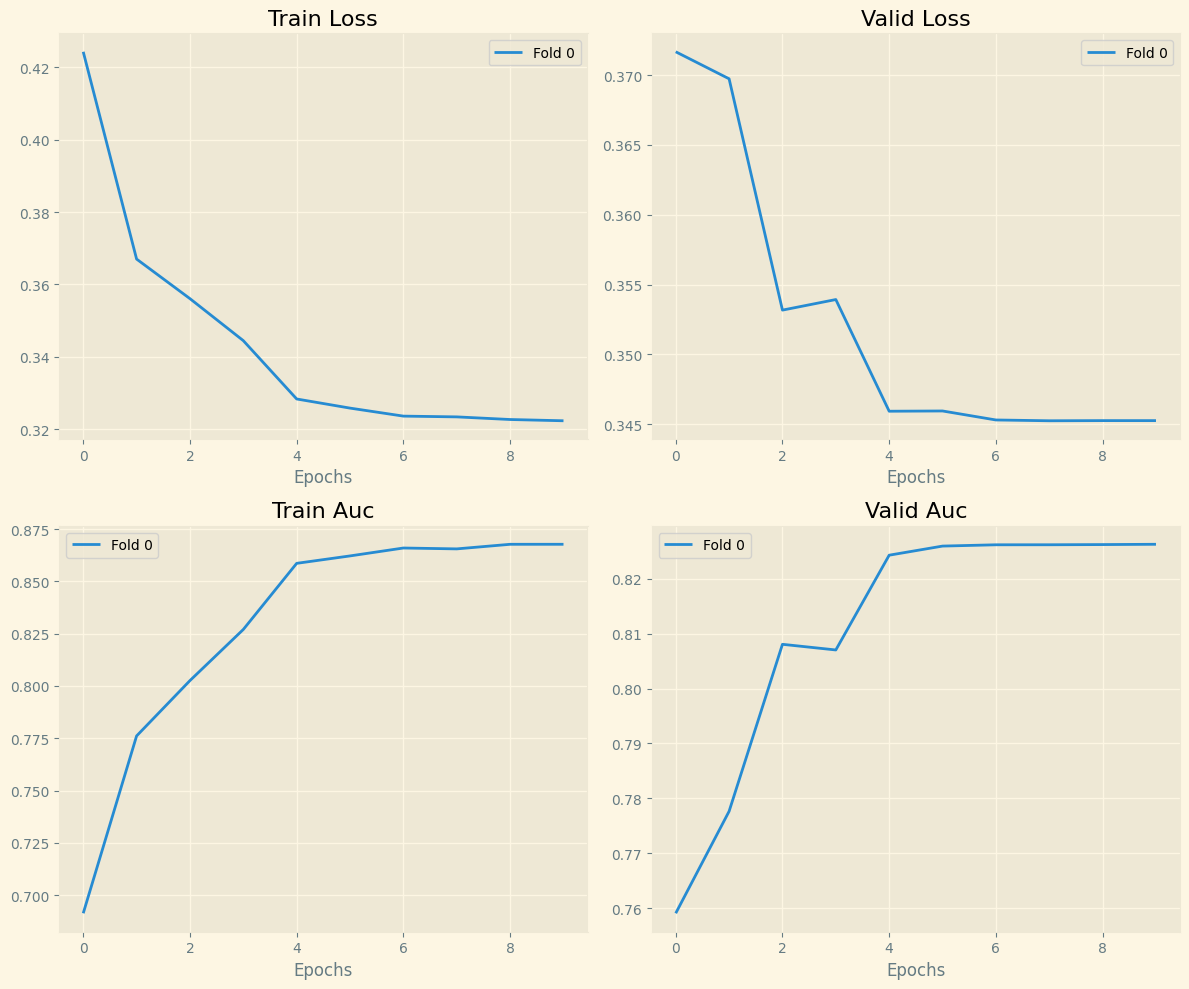

In [121]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('Train Auc')
    for fold, i in enumerate(all_history['Train Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.title('Valid Auc')
    for fold, i in enumerate(all_history['Valid Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

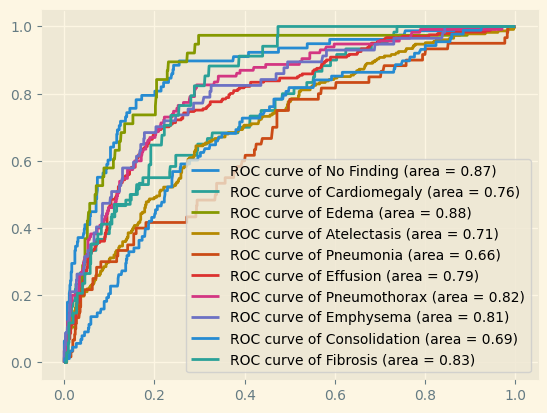

In [122]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [123]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.7814105401396629


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Inference</b></div>

In [124]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=preprocessing)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}Vit_f{i}.weights.h5')
    else: 
        model.load_weights(f'Vit_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
auc_score = roc_auc_score(df_test[TARGET], pred_res, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Test Set =', auc_score)

Fold 1
16/16 [==============================] - 43s 3s/step
AUC for Test Set = 0.7581412697311614


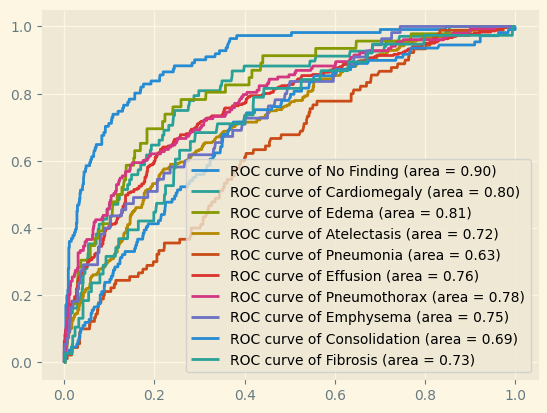

In [125]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()